In [1]:
# EnPI 예측 모델
%load_ext tensorboard

import pathlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import shutil
import functools
import pandas as pd 
import seaborn as sbn 
from tensorflow import keras
import datetime, os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
#Read csv data from the file and creat a dataset
#csv data file path
path = "/content/drive/MyDrive/EnPI/동은단조/학습데이터(1~12)/합계처리(일요일제거)"
data = "full"
data_path = path+"/"+data+"_train.csv"
data_pd=pd.read_csv(data_path)
columns= data_pd.shape[1]
data_size= data_pd.shape[0]
print(columns)
#print(rows)

#data_size = 366
train_output = "energy"

#Define a read csv filee
def get_dataset(file_path, **kwargs):
    dataset = tf.data.experimental.make_csv_dataset(
        file_path,
        batch_size = data_size,
        label_name = train_output,
        na_value = "?",
        ignore_errors = True,
        **kwargs)
    return dataset

#column_name = ['pca1', 'pca2', 'pca3','	'energy']
#DEFAULTS = [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]      #type of the column data
raw_data_train = get_dataset(data_path,
                            select_columns = list(data_pd)
                             )

#Define a show_batch function to see the dataset
#this funcion is not necessary for programe
def show_batch(dataset):
    for batch, label in dataset.take(1):
        for key, value in batch.items():
            print("{:20s}: {}".format(key, value.numpy()))

#show_batch(raw_data_train)            

#Processing data befor feeding into model
#funcion pack together all the column
def pack(feartures, label): 
    return tf.stack(list(feartures.values()), axis = -1), label

packed_dataset = raw_data_train.map(pack)    
for feartures, labels in packed_dataset.take(1):
    None

# Slit data into test, eval and predict
eval_size = 60    # 10%
predict_size = 0
train_size = data_size - eval_size - predict_size   #remain data is training

train_x, eval_x, predict_x = feartures[:train_size,:], feartures[train_size:train_size+eval_size,:], feartures[train_size+eval_size:,:]
train_y, eval_y, predict_y = labels[:train_size], labels[train_size:train_size+eval_size], labels[data_size-predict_size:]

## 데이터 정규화
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
scaler.fit(train_x)
train_x = scaler.transform(train_x)
eval_x = scaler.transform(eval_x)
#predict_x = scaler.transform(predict_x)

#import joblib
#file_name = '발전기전기자_scaler(10).pkl'
#scaler = joblib.load(file_name)

##inspect data using seaborn

data_x_array = np.array(train_x)
data_y_array = np.array(train_y).reshape(len(train_y),1)
data_xy_array = np.concatenate((data_x_array,data_y_array), axis =1)
#header = ['450TON',	'600TON',	'800TON',	'1600TON-1',	'1600TON-2',	'2000TON',	'AUTO 2500-1',	'AUTO 2500-2',	'AUTO 2500-3',	'AUTO 3000-1',	'AUTO 3000-2',	'AUTO 3000-3',	'1_total',	'2_total',	'energy']
dataframe = pd.DataFrame(data_xy_array, columns= list(data_pd))
print(dataframe)
column= dataframe.shape[1]

7
      1_total   1600TON   2000TON  AUTO 2500  AUTO 3000   2_total       energy
0    0.961887  0.690476  0.656549   0.936538   0.607133  0.913375  1378.897949
1    0.551459  0.619462  0.507989   0.719649   0.541646  0.755079  1050.421265
2    0.155197  0.750221  0.739064   0.623177   0.516122  0.742183   982.660583
3    0.640686  0.596150  0.538793   0.594784   0.511506  0.682606  1009.571350
4    0.424581  0.258535  0.528361   0.667760   0.255814  0.529129   947.702393
..        ...       ...       ...        ...        ...       ...          ...
248  0.722611  0.630041  0.488233   0.301627   0.346468  0.464160   880.127991
249  0.509035  0.298558  0.549760   0.499271   0.454966  0.565429  1197.720581
250  0.000000  0.000000  0.000000   0.000000   0.000000  0.000000    25.118208
251  0.679968  0.332809  0.904629   0.347668   0.322602  0.469832   488.577026
252  0.652989  0.846978  0.785928   0.699106   0.744990  0.915611  1312.865234

[253 rows x 7 columns]


In [27]:
#Define ANN model and training method
input_node = column-1
hid1_node = 16 #// 노드 갯수를 올렸을 때 이전과 같으면 더이상 증가 ㄴㄴ
hid2_node = 32
hid3_node = 64
hid4_node = 32
hid5_node = 16
output_node = 1
initializer = tf.keras.initializers.HeNormal()
#regularizer=tf.keras.regularizers.l2()

def build_model():
    return tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=1, activation = 'relu', input_shape = (input_node,1)),
        tf.keras.layers.MaxPooling1D(pool_size=1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(hid1_node, activation = 'relu', input_shape = (input_node,)),
        tf.keras.layers.Dense(hid2_node, activation = 'relu', kernel_initializer=initializer),
        #tf.keras.layers.Dense(hid3_node, activation = 'relu'),
        #tf.keras.layers.Dense(hid4_node, activation = 'relu'),
        #tf.keras.layers.Dense(hid5_node, activation = 'relu'),
        tf.keras.layers.Dense(output_node, activation='softplus')
    ])

model = build_model()
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics = ['mae', 'mape'])


#Check the network model, weights
model.summary()

Epochs = 150 #// train 주기횟수
log_dir = os.path.join("logs",
                        "fit",
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq =1)

batch_fit = 2 #//100 이하로 설정
verbose_fit = 1 #//verbose 1일시 학습상황 확인가능

history = model.fit(train_x, train_y,
                    validation_data = (eval_x, eval_y),
                    epochs = Epochs,
                    batch_size = batch_fit,
                    verbose = verbose_fit,)

#Save the trained model

model.save(path+'/결과/'+data+'.h5')

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 6, 64)             128       
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 6, 64)            0         
 1D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 384)               0         
                                                                 
 dense_21 (Dense)            (None, 16)                6160      
                                                                 
 dense_22 (Dense)            (None, 32)                544       
                                                                 
 dense_23 (Dense)            (None, 1)                 33        
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


127/127 [==============================] - 2s 7ms/step - loss: 912296.7500 - mae: 905.2980 - mape: 96.0521 - val_loss: 645777.6250 - val_mae: 751.9642 - val_mape: 87.2666
Epoch 2/150
127/127 [==============================] - 1s 5ms/step - loss: 272649.9688 - mae: 429.2241 - mape: 66.1263 - val_loss: 65648.2891 - val_mae: 193.5564 - val_mape: 114.7182
Epoch 3/150
127/127 [==============================] - 1s 7ms/step - loss: 44857.0586 - mae: 171.8488 - mape: 61.1074 - val_loss: 69817.1016 - val_mae: 195.0735 - val_mape: 119.0952
Epoch 4/150
127/127 [==============================] - 1s 6ms/step - loss: 44399.2891 - mae: 167.1440 - mape: 60.7295 - val_loss: 64678.1055 - val_mae: 191.8788 - val_mape: 111.9116
Epoch 5/150
127/127 [==============================] - 1s 5ms/step - loss: 43044.5508 - mae: 166.3853 - mape: 59.7573 - val_loss: 63559.9492 - val_mae: 191.8512 - val_mape: 108.8617
Epoch 6/150
127/127 [==============================] - 1s 6ms/step - loss: 43094.3203 - mae: 167.595

7


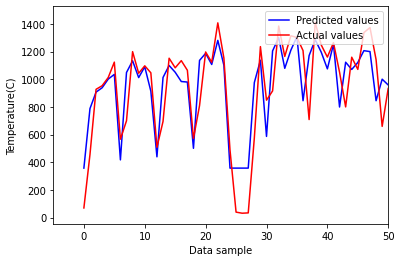

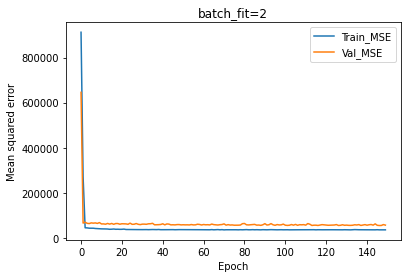

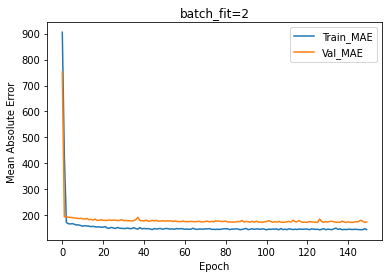

[58.90350728]


In [28]:
#Load the trained model
data_path = path+"/"+data+"_test.csv"
#print('total')
dfs = pd.read_csv(data_path)
columns= dfs.shape[1]
predict_size= dfs.shape[0]
print(columns)
#print(rows)
data_path=np.array(dfs)
#predict_size=12
predict_x = data_path[:predict_size,0:columns-1]
predict_y = data_path[:predict_size,columns-1:columns]
predict_x = scaler.transform(predict_x)


predict_output = model.predict(predict_x)
real_predict_array = np.array(predict_y).reshape(predict_size,1)
predictor_error = abs(predict_output - real_predict_array)
predictor_error2 = abs(predict_output - real_predict_array)/real_predict_array
MAE = sum(predictor_error)/len(predictor_error)
MAPE = sum(predictor_error2)/len(predictor_error2)*100

#Save weight and bias matrix to csv file
import numpy

plt.plot(predict_output,'b-', label='Predicted values')
plt.plot(predict_y,'r-', label='Actual values')
plt.xlabel('Data sample')
plt.ylabel('Temperature(C)')
plt.legend(loc='upper right')
#plt.ylim(-5, 119)
plt.xlim(-5, 50)
plt.show()
#check the data
#mse, mae = model.evaluate(eval_x, eval_y, verbose = 2)

#결과저장
import csv
np.set_printoptions(suppress=True)
with open(path+'/결과/'+data+'_test2.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Predicted power", "Actual power", "error", "MAE", "MAPE"])
    writer.writerow(["", "", "", MAE[0], MAPE[0]])
    for i in range(len(predict_output)):
        writer.writerow([predict_output[i][0], real_predict_array[i][0], predictor_error[i][0]])
    
#plot resutls
plt.plot(history.history['loss'], label = 'Train_MSE')
plt.plot(history.history['val_loss'], label = 'Val_MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean squared error')
plt.title('batch_fit='+str(batch_fit))
plt.legend(loc='upper right')
plt.show()

plt.plot(history.history['mae'], label = 'Train_MAE')
plt.plot(history.history['val_mae'], label = 'Val_MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('batch_fit='+str(batch_fit))
plt.legend(loc='upper right')
plt.show()

print(MAPE)
